<img src="https://raw.githubusercontent.com/StanfordSocialNeuroscienceLab/json-parser/main/.images/SSNL.jpg" width=75%>




# fMRI Processing Pipeline

## Single-Subject Object Demo

In [1]:
# Imports
import os, warnings, json
warnings.filterwarnings('ignore')

from nilearn import image
import nilearn.plotting as nip

try:
    os.chdir('/Users/ianferguson/Box Sync/Research/SCP/0-fMRI/Ian-NiPype')
except:
    os.chdir('/Users/IanFerguson 1/Box Sync/Research/SCP/0-fMRI/Ian-NiPype')

----------

### Instantiating an SCP_Sub object

In [2]:
from communities import SCP_Sub
sub = SCP_Sub('01024', 'faces', suppress=False)

{
    "Subject ID": "01024",
    "Task": "faces",
    "# of Functional Runs": 1,
    "Functional Runs": [
        "./bids/sub-01024/func/sub-01024_task-faces_run-1_bold.nii.gz"
    ],
    "Path to Output Directory": "./bids/derivatives/first-level/sub-01024/task-faces"
}


The `SCP_Sub` object interacts directly with an external JSON file `./task_information.json`, which allows you to easily modify various components of your first-level model estimation. The `SCP_Sub` object implicitly reads the task information file when itialized:

In [3]:
sub._taskfile_validator()

{'conditions': ['nondorm', 'dorm', 'attention_check'],
 'confound_regressors': ['framewise_displacement',
  'dvars',
  'csf',
  'trans_x',
  'trans_y',
  'trans_z',
  'rot_x',
  'rot_y',
  'rot_z',
  'white_matter'],
 'network_regressors': ['indegree_CloseFrds_fa18', 'Need_Belong'],
 'block_regressors': [],
 'trial_type': 'condition',
 'tr': 1.0,
 'excludes': ['02013', '02031', '02037', '02045', '02060', '05061'],
 'design-contrasts': {'dorm-membership': 'dorm-membership',
  'indegree': 'indegree_CloseFrds_fa18'},
 'design-type': 'event',
 'group-level-regressors': ['indegree_CloseFrds_fa18',
  'outdegree_CloseFrds_fa18',
  'Extraversion',
  'Agreeableness',
  'Openness',
  'Conscientiousness',
  'EmotionalStability',
  'Loneliness',
  'Self_Esteem',
  'STAI_Anxiety']}

In [4]:
sub.conditions

['nondorm', 'dorm', 'attention_check']

The task information file contains fields for **confound** and **network** regressors

* **Confound regressors** are derived from fmriprep, and correct for in-scanner artifacts, motion, CSF, and the like
    * Our `SCP_Sub` object reads these in from the confounds CSV located under `derivatives/fmriprep/{sub-id}`
    
    
* We define **network regressors** as personality covariates derived from the Stanford Communities Project. This allows us to factor various network traits (e.g., network centrality) into our models - for example, the popularity of a target that a participant might see in one of the functional tasks

In [5]:
sub.confound_regressors

['framewise_displacement',
 'dvars',
 'csf',
 'trans_x',
 'trans_y',
 'trans_z',
 'rot_x',
 'rot_y',
 'rot_z',
 'white_matter']

In [6]:
sub.network_regressors

['indegree_CloseFrds_fa18', 'Need_Belong']

You have the option to either define your contrasts a priori, or let the `SCP_Sub` object do it for you. When you leave the contrasts field of the task information file empty, the `_default_contrasts()` function will simply loop through your defined conditions and compute pairwise contrasts (e.g., dorm - nondorm, dorm - attention, attention - nondorm)

In [7]:
# Pre-defined contrasts
sub.contrasts

{'dorm-membership': 'dorm-membership', 'indegree': 'indegree_CloseFrds_fa18'}

In [8]:
# Contrasts defined by the script
sub._default_contrasts()

{'nondorm-dorm': 'nondorm-dorm', 'dorm-nondorm': 'dorm-nondorm'}

In the spirit of data organization, this object implicitly organizes the outputs of your modeling into task-specific directories under the derivatives folder in your BIDS project. Z-maps are saved as `.nii.gz` files and plots of each condtion map and contrast map are saved automatically

In [9]:
%%bash
tree ./bids/derivatives/first-level/sub-01024/task-faces/

./bids/derivatives/first-level/sub-01024/task-faces/
├── first-level-model
│   ├── condition-maps
│   │   ├── sub-01024_condition-attention_z-map.nii.gz
│   │   └── sub-01024_condition-face_z-map.nii.gz
│   └── contrast-maps
│       ├── sub-01024_contrast-dorm-membership_z-map.nii.gz
│       └── sub-01024_contrast-indegree_z-map.nii.gz
└── plotting
    ├── condition-maps
    │   ├── glass
    │   │   ├── sub-01024_condition-attention_plot-glass-brain.png
    │   │   └── sub-01024_condition-face_plot-glass-brain.png
    │   ├── stat
    │   │   ├── sub-01024_condition-attention_plot-stat-map.png
    │   │   └── sub-01024_condition-face_plot-stat-map.png
    │   └── summary
    │       ├── sub-01024_condition-attention_summary.html
    │       └── sub-01024_condition-face_summary.html
    ├── contrast-maps
    │   ├── glass
    │   │   ├── sub-01024_contrast-dorm-membership_plot-glass-brain.png
    │   │   └── sub-01024_contrast-indegree_plot-glass-brain.png
    │   ├── stat
    │   │   

In [10]:
sub.nilearn_first_level_condition

'./bids/derivatives/first-level/sub-01024/task-faces/first-level-model/condition-maps'

---------

### GLM Estimation

We achieve first-level model estimation in two steps:

* Run-wise design matrices are computed using one of two functions
    * Event-design tasks utilize the `.firstLevel_event_design()` function
    * Block-design tasks utilize the `.firstLevel_block_design()` function
    * To maximize contrast flexibility, block design tasks pair up the block and task into a new regressor in the design matrix - e.g., high_trust_perspective, high_trust_valence, low_trust_perspective, low_trust_valence
    
    
* The design function returns a list of design matrices, which are then fed into a Nilearn `FirstLevelModel` object


* The model is run and contrasts are automatically computed (see above)


* The resulting output is then saved in the directory hierarchy outlined earlier

In [11]:
dm = sub.firstLevel_event_design()

dm[0]

,attention,face,framewise_displacement,dvars,csf,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,white_matter,dorm-membership,indegree_CloseFrds_fa18,Need_Belong,drift_1,drift_2,drift_3,constant
0.0,0.0,0.000000,0.074613,18.311851,17922.080496,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,13577.829449,0.0,0.0,0.0,-0.500000,0.166297,-0.049668,1.0
1.0,0.0,0.000000,0.000000,0.000000,17922.080496,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,13577.829449,0.0,0.0,0.0,-0.497783,0.164085,-0.048346,1.0
2.0,0.0,0.000000,0.093950,37.070644,17127.802400,-0.005424,-0.014816,0.066328,0.000000,-0.000000,0.000148,13542.568669,0.0,0.0,0.0,-0.495565,0.161882,-0.047040,1.0
3.0,0.0,0.000000,0.048047,20.336132,17010.496501,-0.000040,0.017229,0.070281,-0.000074,-0.000000,0.000207,13543.572255,0.0,0.0,0.0,-0.493348,0.159689,-0.045747,1.0
4.0,0.0,0.000000,0.077481,18.898760,16971.937020,-0.000031,0.018511,0.017403,0.000268,0.000092,0.000174,13555.955884,0.0,0.0,0.0,-0.491131,0.157507,-0.044470,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447.0,0.0,-0.014046,0.038307,17.682770,16743.205394,0.072617,0.520266,0.068328,0.004845,-0.001406,-0.001763,13418.186735,0.0,0.0,0.0,0.491131,0.157507,0.044470,1.0
448.0,0.0,-0.022499,0.067741,16.572853,16776.651764,0.085176,0.500232,0.043207,0.004815,-0.001576,-0.001763,13408.272541,0.0,0.0,0.0,0.493348,0.159689,0.045747,1.0
449.0,0.0,-0.026635,0.088677,19.762093,16765.919498,0.059793,0.490640,0.057138,0.004683,-0.001624,-0.001148,13408.452302,0.0,0.0,0.0,0.495565,0.161882,0.047040,1.0
450.0,0.0,-0.027575,0.083730,19.008163,16737.687976,0.071598,0.511560,0.082709,0.004722,-0.001556,-0.001550,13396.423875,0.0,0.0,0.0,0.497783,0.164085,0.048346,1.0


In [12]:
sub.firstLevel_contrasts(conditions=False)


--------- Fitting model, please hold...


  0%|                                                     | 0/2 [00:00<?, ?it/s]


--------- Mapping contrast z-scores



100%|█████████████████████████████████████████████| 2/2 [00:23<00:00, 11.93s/it]


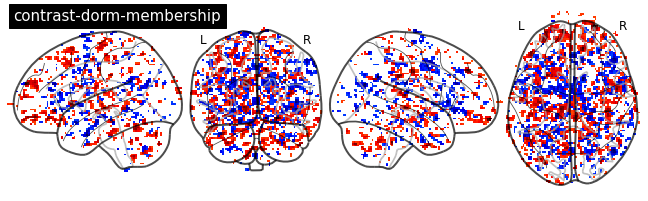

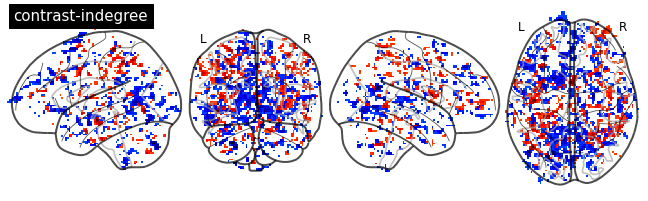

In [13]:
for z_map in os.listdir(sub.nilearn_first_level_contrasts):
    z = image.load_img(os.path.join(sub.nilearn_first_level_contrasts, z_map))
    title = z_map.split('/')[-1].split('_')[1]
    
    nip.plot_glass_brain(z, title=title, threshold=2.3, plot_abs=False, colorbar=False, display_mode='lyrz')

--------